In [1]:
import pandas as pd
import seaborn as sns
import torch
import torch.distributions as dist
import torch.nn as nn


import beanmachine.ppl as bm
from beanmachine.ppl.experimental.vi.variational_infer import MeanFieldVariationalInference

sns.set_style("darkgrid")

# Normal Normal

In [2]:
class NormalNormal:
    @bm.random_variable
    def mu(self):
        return dist.Normal(1, 1)

    @bm.random_variable
    def x(self, i):
        return dist.Normal(self.mu(), 1)


model = NormalNormal()
queries = [model.mu()]
obs = {
    model.x(0): torch.tensor(10.0),
}


def true_log_prob(x):
    tau_0 = 1.0**-2
    tau_1 = 1.0**-2
    return dist.Normal((tau_1 / (tau_0 + tau_1)) * 10.0, (tau_0 + tau_1)**-1).log_prob(x)

In [3]:
vi = MeanFieldVariationalInference()
vi_dicts = vi.infer(queries, obs, base_dist=dist.Normal, base_args={
    'loc': torch.tensor(0.),
    'scale': torch.tensor(1.),
}, num_iter=100, lr=3e-1)

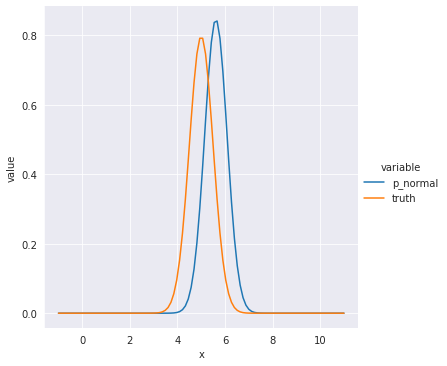

In [4]:
x = torch.linspace(-1, 11, steps=100).unsqueeze(1)
p_normal = torch.exp(vi_dicts[model.mu()].log_prob(x))
sns.relplot(data=pd.DataFrame({
    "x": x.flatten().detach().numpy(),
    "p_normal": p_normal.flatten().detach().numpy(),
    "truth":  torch.exp(true_log_prob(x)).flatten().detach().numpy(),
}).melt(id_vars=["x"]), x="x", y="value", hue="variable", kind="line")

In [5]:
vi_dicts[model.mu()].sample((100,)).mean()

tensor(5.5969)

# Using a heavy-tailed base distribution

In [6]:
vi = MeanFieldVariationalInference()

vi_dicts_student = vi.infer(
    queries, obs, 
    base_dist=dist.StudentT,
    base_args={
        #'df': torch.tensor(1000000.0),
        'df': nn.Parameter(torch.tensor(10.0)),
        'loc': torch.tensor(0.0),
        #'loc': nn.Parameter(torch.tensor(0.0)),
        #'scale': torch.tensor(1.0),
        #'scale': nn.Parameter(torch.tensor(1.0)),
    },
    num_iter=100, lr=1)

#)

In [7]:
fs = vi_dicts_student[model.mu()].flow_stack
fs.base_dist(**fs.base_args)

StudentT(df: 6.599262237548828, loc: 0.0, scale: 1.0)

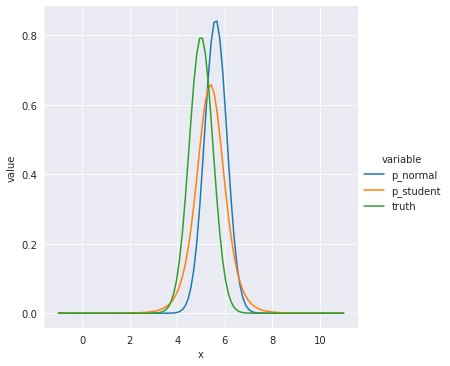

In [8]:
p_student = torch.exp(vi_dicts_student[model.mu()].log_prob(x))
sns.relplot(data=pd.DataFrame({
    "x": x.flatten().detach().numpy(),
    "p_normal": p_normal.flatten().detach().numpy(),
    "p_student": p_student.flatten().detach().numpy(),
    "truth":  torch.exp(true_log_prob(x)).flatten().detach().numpy(),
}).melt(id_vars=["x"]), x="x", y="value", hue="variable", kind="line")

# Scale Mixture Representation for StudentT
[Ref](https://proceedings.neurips.cc/paper/2009/file/13fe9d84310e77f13a6d184dbf1232f3-Paper.pdf)

In [ ]:
df = 3.0
loc = 1.0

@bm.random_variable
def W_inv(i):
    return dist.Gamma(concentration=0.5*df, rate=0.5*df)


@bm.random_variable
def y(i):
    return dist.Normal(loc, 1.0 / torch.sqrt(W_inv(i).abs()))


vi = MeanFieldVariationalInference()
vi_student_df = vi.infer(
    [y(0)], {},
    base_dist=dist.StudentT,
    base_args={
        'df': nn.Parameter(torch.tensor(df)),
        #'loc': torch.tensor(0.),
        #'scale': torch.tensor(1.),
    },
    num_iter=100, lr=1e-1
)
vi_student_oracle = vi.infer(
    [y(0)], {},
    base_dist=dist.StudentT,
    base_args={
        'df': torch.tensor(df),
        #'loc': torch.tensor(0.),
        #'scale': torch.tensor(1.),
    },
    num_iter=100, lr=1e-1
)
vi_normal = vi.infer(
    [y(0)], {},
    num_iter=1000, lr=1,
    base_dist=dist.Normal,
    base_args={
        'loc': nn.Parameter(torch.tensor(0.)),
        'scale': torch.tensor(1.),
    }
)


def true_log_prob(x):
    return dist.StudentT(loc=loc, df=df).log_prob(x)

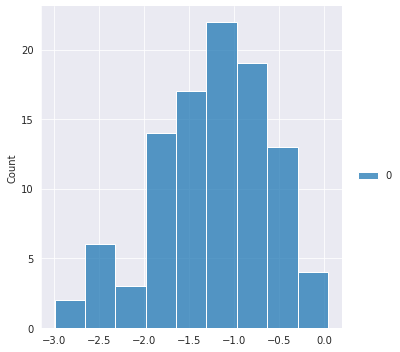

In [18]:
sns.displot(vi_normal[W_inv(0)].sample((100,)).numpy())

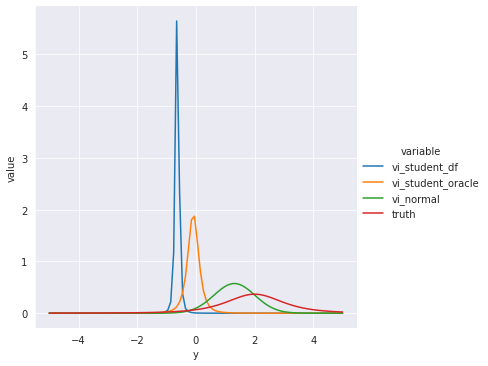

In [19]:
x = torch.linspace(-5, 5, steps=100).unsqueeze(1)
p_true = torch.exp(true_log_prob(x))
sns.relplot(data=pd.DataFrame({
    "y": x.flatten().detach().numpy(),
    "vi_student_df": torch.exp(vi_student_df[y(0)].log_prob(x)).flatten().detach().numpy(),
    "vi_student_oracle": torch.exp(vi_student_oracle[y(0)].log_prob(x)).flatten().detach().numpy(),
    "vi_normal": torch.exp(vi_normal[y(0)].log_prob(x)).flatten().detach().numpy(),
    "truth": p_true.flatten().detach().numpy(),
}).melt(id_vars=["y"]), x="y", y="value", hue="variable", kind="line")

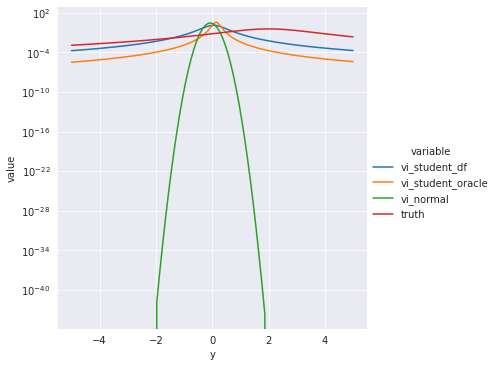

In [16]:
g = sns.relplot(data=pd.DataFrame({
    "y": x.flatten().detach().numpy(),
    "vi_student_df": torch.exp(vi_student_df[y(0)].log_prob(x)).flatten().detach().numpy(),
    "vi_student_oracle": torch.exp(vi_student_oracle[y(0)].log_prob(x)).flatten().detach().numpy(),
    "vi_normal": torch.exp(vi_normal[y(0)].log_prob(x)).flatten().detach().numpy(),
    "truth": p_true.flatten().detach().numpy(),
}).melt(id_vars=["y"]), x="y", y="value", hue="variable", kind="line")
g.set(yscale='log')